In [122]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
# style.use('ggplot')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Find the latest date by sorting dates in descending order and displaying the first date
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [11]:
# Use the inspector to view the column names and data types

inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column)

{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}
{'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'date', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'prcp', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'tobs', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_12_m = session.query(Measurement.date).filter(Measurement.date > '2016-08-22').order_by(Measurement.date).all()

# Calculate the date 1 year ago from the last data point in the database
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(f"Query Date: {query_date}")

# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > query_date).all()
precip_data
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip_data,columns = ['Date','Precipitation'])
precip_df.set_index('Date',inplace=True)
precip_df.head(15)

Query Date: 2016-08-23


,Precipitation
Date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01
2016-08-29,0.00
2016-08-30,0.00
2016-08-31,0.13
2016-09-01,0.00


In [13]:
import matplotlib.dates as mdates

Text(2400, 3, 'NB: Data not available for dates with no line')

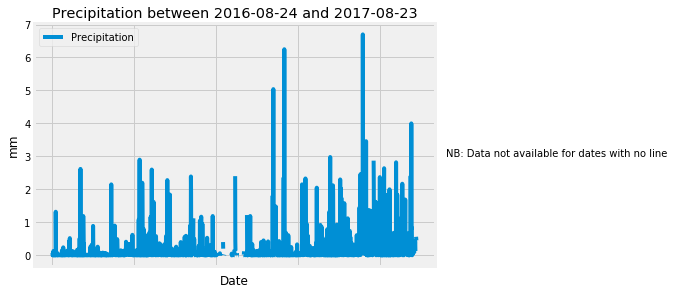

In [109]:
#### # Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(kind='line')
plt.tight_layout()
plt.ylabel("mm")
plt.title("Precipitation between 2016-08-24 and 2017-08-23")
months = mdates.MonthLocator()
# ax.xaxis.set_major_locator(months)
plt.text(2400,3,"NB: Data not available for dates with no line")

![precipitation](Images/precipitation.png)

In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [16]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).group_by(Measurement.station).count()

9

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

# Query the data, grouping by station name and counting the stations. Orde by the most frequently occurring station.
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
highest_temp = session.query(Measurement.station, func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').\
    order_by(func.max(Measurement.tobs).desc()).first()
print(f"Highest temp at most active station: {highest_temp}")

lowest_temp = session.query(Measurement.station, func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').\
    order_by(func.min(Measurement.tobs).desc()).first()
print(f"Lowest temp at most active station: {lowest_temp}")

avg_temp = session.query(Measurement.station, func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').\
    order_by(func.avg(Measurement.tobs).desc()).first()
print(f"Average temp at most active station: {avg_temp}")



Highest temp at most active station: ('USC00519281', 85.0)
Lowest temp at most active station: ('USC00519281', 54.0)
Average temp at most active station: ('USC00519281', 71.66378066378067)


In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Group by count of temperature points, 
temp_data_most_active_station = session.query(Measurement.tobs, func.count(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').filter(Measurement.date > query_date).\
    group_by(Measurement.tobs).order_by(Measurement.tobs).all()
temp_data_most_active_station
# Convert the data into a Pandas Dataframe and name columns
temp_data_df = pd.DataFrame(temp_data_most_active_station,columns=["Temperature","Frequency"])

# Set the Date to be the index.
temp_data_df.set_index("Temperature",inplace=True)

# Show the first 15 rows of the dataframe
temp_data_df



,Frequency
Temperature,
59.0,3
60.0,2
61.0,1
62.0,6
63.0,4
64.0,3
65.0,7
66.0,5
67.0,15


Text(0.5, 1.0, 'Temperatures for Station USC00519281 - Aug 2016 - Aug 2017')

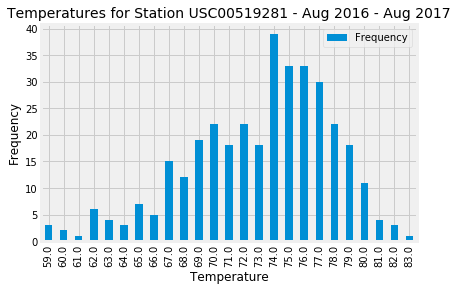

In [115]:
temp_data_df.plot(kind='bar')
plt.ylabel("Frequency",size=12)
# plt.xlabel()
plt.title("Temperatures for Station USC00519281 - Aug 2016 - Aug 2017",size=14)


![precipitation](Images/station-histogram.png)

In [59]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [56]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# print(calc_temps('2016-02-28','2017-03-05'))
temp_stats = pd.DataFrame(calc_temps('2011-02-28','2011-03-05'),columns=["Min Temp","Avg Temp","Max Temp"])
temp_stats

,Min Temp,Avg Temp,Max Temp
0,61.0,69.755102,75.0


Text(0, 0.5, 'Temp (F)')

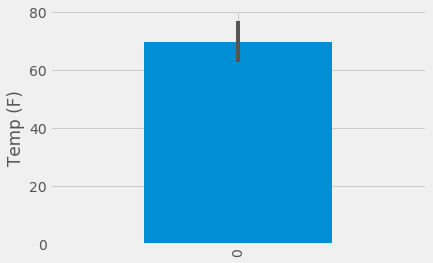

In [123]:
# Plot the results from your previous query as a bar chart.
std = np.std([temp_stats["Max Temp"], temp_stats["Min Temp"]])
temp_stats["Avg Temp"].plot(x=0.5,kind='bar',yerr=std)
# Use "Trip Avg Temp" as your Title
# plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


Text(0.5, 1.0, 'Trip Avg Temp')

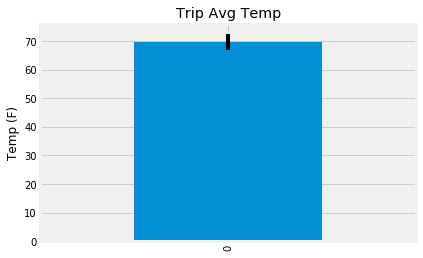

In [94]:
# Calculate the standard deviation for all temperatures within date range using the standard deviation 
# of all temperatures as the yerror

# Query the data to product temperatures within date range 2011-02-08 and 2011-03-05
all_temps = session.query(Measurement.tobs,Measurement.date).filter(Measurement.date >= '2011-02-28').\
    filter(Measurement.date <= '2011-03-05').all()
# Put the results in a dataframe
all_temps_df = pd.DataFrame(all_temps,columns=["Temperatures", "Dates"])
# Calculate the standard deviation of all temperatures
temps_std = np.std(all_temps_df["Temperatures"])
# Plot the results
temp_stats["Avg Temp"].plot(kind='bar',yerr=temps_std)
plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp")

In [140]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

total_prcp = engine.execute("select s.station, s.latitude, s.longitude, s.elevation, sum(m.prcp) as 'total_prcp'\
                            from Station as s\
                            join Measurement as m on s.station=m.station\
                            where m.date <= '2011-03-05' and m.date >= '2011-02-28'\
                            group by m.station\
                            order by 'total_prcp' DESC;").fetchall()
total_prcp

[('USC00511918', 21.3152, -157.9992, 0.9, 0.63),
 ('USC00513117', 21.4234, -157.8015, 14.6, 1.44),
 ('USC00514830', 21.5213, -157.8374, 7.0, 1.96),
 ('USC00516128', 21.3331, -157.8025, 152.4, 1.45),
 ('USC00517948', 21.3934, -157.9751, 11.9, None),
 ('USC00518838', 21.4992, -158.0111, 306.6, 2.33),
 ('USC00519281', 21.45167, -157.84888999999998, 32.9, 2.23),
 ('USC00519397', 21.2716, -157.8168, 3.0, 1.38),
 ('USC00519523', 21.33556, -157.71139, 19.5, 2.19)]

In [146]:
# Put the data in a pandas dataframe and sort by total precipitation

total_prcp_df = pd.DataFrame(total_prcp,columns = ["Station","Latitude","Longitude","Elevation","Total Precipitation"])
total_prcp_df.sort_values("Total Precipitation",ascending=False,inplace=True)
total_prcp_df

,Station,Latitude,Longitude,Elevation,Total Precipitation
5,USC00518838,21.49920,-158.01110,306.6,2.33
6,USC00519281,21.45167,-157.84889,32.9,2.23
8,USC00519523,21.33556,-157.71139,19.5,2.19
2,USC00514830,21.52130,-157.83740,7.0,1.96
3,USC00516128,21.33310,-157.80250,152.4,1.45
1,USC00513117,21.42340,-157.80150,14.6,1.44
7,USC00519397,21.27160,-157.81680,3.0,1.38
0,USC00511918,21.31520,-157.99920,0.9,0.63
4,USC00517948,21.39340,-157.97510,11.9,NaN


## Optional Challenge Assignment

In [147]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [211]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2011-02-28'
end_date = '2011-03-05'

# Use the start and end date to create a range of dates
dates_in_range = pd.date_range(start_date,end_date)
dates_in_range

# Strip off the year and save a list of %m-%d strings
date_count=0
daily_normals_df = pd.DataFrame(columns=["Date","Min","Avg","Max"])
for dt in dates_in_range:
    dt = dt.strftime("%m-%d")
    normals = daily_normals(dt)[0]
    daily_normals_df.loc[date_count,"Date"]=dt
    daily_normals_df.loc[date_count,["Min","Avg","Max"]]=normals
    date_count+=1

daily_normals_df.set_index("Date",drop=True,inplace=True)
daily_normals_df


,Min,Avg,Max
Date,,,
02-28,65,70.6552,80
03-01,64,70.0328,76
03-02,61,70.3667,78
03-03,60,70.069,78
03-04,57,69.2727,77
03-05,60,67.8909,76


Text(0.5, 1.0, 'Daily Normal Temps for 02-28 to 03-05 2011')

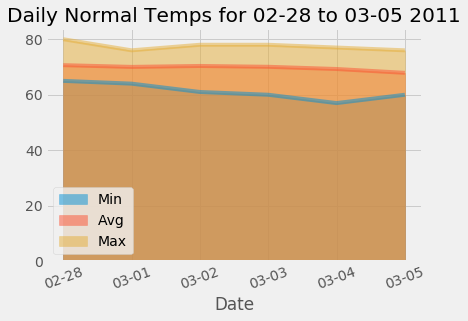

In [231]:
# Plot the daily normals as an area plot with `stacked=False`
daily_normals_df.plot(kind='area',stacked=False)
plt.xticks(np.arange(6),["02-28","03-01","03-02","03-03","03-04","03-05"],rotation=20)
plt.title("Daily Normal Temps for 02-28 to 03-05 2011")